<a href="https://colab.research.google.com/github/gantir/eva4/blob/develop/s4/EVA4_Session_4.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
from __future__ import print_function
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms

from matplotlib import pyplot as plt
from tqdm import tqdm
import numpy as np

In [14]:
!pip install torchsummary
from torchsummary import summary
use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")


In [0]:
from tqdm import tqdm
def train(model, device, train_loader, optimizer, epoch):
    model.train()
    train_loss = 0
    train_correct = 0
    train_acc = 0
    pbar = tqdm(train_loader)
    for batch_idx, (data, target) in enumerate(pbar):
        data, target = data.to(device), target.to(device)
        optimizer.zero_grad()
        output = model(data)
        loss = F.nll_loss(output, target)
        
        pred_train = output.argmax(dim=1, keepdim=True)
        train_correct += pred_train.eq(target.view_as(pred_train)).sum().item()

        loss.backward()
        optimizer.step()
        
        train_loss = loss.item()
        train_acc = 100. * train_correct / len(train_loader.dataset)

        output_message = 'Epoch: {}, Batch Id: {} Training Loss: {:.8f} Training Accuracy: {:.4f}%'.format(epoch, batch_idx, train_loss,train_acc)
        pbar.set_description(desc= output_message)

    return train_acc, train_loss

def test(model, device, test_loader, epoch=1):
    model.eval()
    test_loss = 0
    correct = 0
    test_acc = 0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            test_loss += F.nll_loss(output, target, reduction='sum').item()  # sum up batch loss
            pred = output.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
            correct += pred.eq(target.view_as(pred)).sum().item()

    test_loss /= len(test_loader.dataset)
    
    test_acc = 100. * correct / len(test_loader.dataset)
    
    output_message = '\nEpoch:{} -- Test Set, Validation Loss: {:.8f} Validation Accuracy: {:.4f}%\n'.format(epoch,test_loss,test_acc)
    print(output_message)

    return test_acc, test_loss

In [0]:
def plot_accuracy(train_history, val_history):
  _= plt.plot(train_history)
  _= plt.plot(val_history)
  _= plt.title('model accuracy')
  _= plt.ylabel('accuracy')
  _= plt.xlabel('epoch')
  _= plt.legend(['train', 'val'], loc='upper left')
  _= plt.show()

def plot_loss(train_history, val_history):
  _= plt.plot(train_history)
  _= plt.plot(val_history)
  _= plt.title('model loss')
  _= plt.ylabel('loss')
  _= plt.xlabel('epoch')
  _= plt.legend(['train', 'val'], loc='upper left')
  _= plt.show()

In [0]:
torch.manual_seed(42)
batch_size = 128

kwargs = {'num_workers': 1, 'pin_memory': True} if use_cuda else {}
train_loader = torch.utils.data.DataLoader(
    datasets.MNIST('../data', train=True, download=True,
                    transform=transforms.Compose([
                        transforms.ToTensor(),
                        transforms.Normalize((0.1307,), (0.3081,))
                    ])),
    batch_size=batch_size, shuffle=True, **kwargs)

test_loader = torch.utils.data.DataLoader(
    datasets.MNIST('../data', train=False, transform=transforms.Compose([
                        transforms.ToTensor(),
                        transforms.Normalize((0.1307,), (0.3081,))
                    ])),
    batch_size=batch_size, shuffle=True, **kwargs)


In [0]:
def train_n_test(model, optimizer, device, train_data_loader, test_data_loader, num_epochs=10):
  train_acc_history = []
  train_loss_history = []
  val_acc_history = []
  val_loss_history = []

  for epoch in range(1, num_epochs+1):
      train_acc, train_loss = train(model, device, train_data_loader, optimizer, epoch)
      train_acc_history.append(train_acc)
      train_loss_history.append(train_loss)

      val_acc, val_loss = test(model, device, test_data_loader, epoch)
      val_acc_history.append(val_acc)
      val_loss_history.append(val_loss)

  plot_accuracy(train_acc_history, val_acc_history)
  plot_loss(train_loss_history, val_loss_history)

  return ([(train_acc_history, train_loss_history),(val_acc_history, val_loss_history)])

In [0]:
class Net1(nn.Module):
    def __init__(self):
        super(Net1, self).__init__()
        self.conv1 = nn.Conv2d(1, 8, 3, bias=False) #input -28*28*1 output: 26*26*8 RF: 3*3
        self.conv2 = nn.Conv2d(8, 8, 3, bias=False) #input -26*26*8 output: 24*24*8 RF: 5*5
        self.conv3 = nn.Conv2d(8, 16, 3, bias=False) #input -24*24*8 output: 22*22*16 RF: 7*7
        self.pool1 = nn.MaxPool2d(2, 2) #input - 22*22*16 output: 11*11*16 RF: 8*8

        self.conv4 = nn.Conv2d(16, 16, 3, bias=False) #input -11*11*16 output: 9*9*16 LRF: 3*3 GRF: 12*12
        self.conv5 = nn.Conv2d(16, 16, 3, bias=False) #input -9*9*16 output: 7*7*16 LRF: 5*5 GRF: 16*16
        
        self.conv6 = nn.Conv2d(16, 10, 1, bias=False) #input -7*7*16 output: 7*7*10 LRF: 5*5 GRF: 16*16
        self.gap = nn.AvgPool2d(kernel_size=7) #input -7*7*10 output: 1*1*10

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = F.relu(self.conv3(F.relu(self.conv2(x))))
        x = self.pool1(x)
        x = F.relu(self.conv5(F.relu(self.conv4(x))))
        x = self.gap(self.conv6(x)) #No activation on conv before last later
        x = x.view(-1, 10)
        return F.log_softmax(x, dim=1)

In [20]:
model1 = Net1().to(device)
summary(model1, input_size=(1, 28, 28))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1            [-1, 8, 26, 26]              72
            Conv2d-2            [-1, 8, 24, 24]             576
            Conv2d-3           [-1, 16, 22, 22]           1,152
         MaxPool2d-4           [-1, 16, 11, 11]               0
            Conv2d-5             [-1, 16, 9, 9]           2,304
            Conv2d-6             [-1, 16, 7, 7]           2,304
            Conv2d-7             [-1, 10, 7, 7]             160
         AvgPool2d-8             [-1, 10, 1, 1]               0
Total params: 6,568
Trainable params: 6,568
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.17
Params size (MB): 0.03
Estimated Total Size (MB): 0.20
----------------------------------------------------------------


Epoch: 1, Batch Id: 468 Training Loss: 0.41632095 Training Accuracy: 37.2250%: 100%|██████████| 469/469 [00:11<00:00, 39.19it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Epoch:1 -- Test Set, Validation Loss: 0.47420193 Validation Accuracy: 85.2900%



Epoch: 2, Batch Id: 468 Training Loss: 0.27156687 Training Accuracy: 88.9000%: 100%|██████████| 469/469 [00:11<00:00, 42.16it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Epoch:2 -- Test Set, Validation Loss: 0.28176117 Validation Accuracy: 90.7000%



Epoch: 3, Batch Id: 468 Training Loss: 0.15725338 Training Accuracy: 93.0433%: 100%|██████████| 469/469 [00:11<00:00, 41.32it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Epoch:3 -- Test Set, Validation Loss: 0.16359772 Validation Accuracy: 95.0300%



Epoch: 4, Batch Id: 468 Training Loss: 0.10170852 Training Accuracy: 94.5950%: 100%|██████████| 469/469 [00:11<00:00, 42.07it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Epoch:4 -- Test Set, Validation Loss: 0.13504305 Validation Accuracy: 95.9100%



Epoch: 5, Batch Id: 468 Training Loss: 0.16310100 Training Accuracy: 95.5517%: 100%|██████████| 469/469 [00:11<00:00, 41.72it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Epoch:5 -- Test Set, Validation Loss: 0.13880270 Validation Accuracy: 95.7200%



Epoch: 6, Batch Id: 468 Training Loss: 0.07513386 Training Accuracy: 96.2383%: 100%|██████████| 469/469 [00:11<00:00, 41.50it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Epoch:6 -- Test Set, Validation Loss: 0.09214761 Validation Accuracy: 97.1000%



Epoch: 7, Batch Id: 468 Training Loss: 0.01359986 Training Accuracy: 96.6783%: 100%|██████████| 469/469 [00:11<00:00, 42.94it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Epoch:7 -- Test Set, Validation Loss: 0.09999667 Validation Accuracy: 97.0300%



Epoch: 8, Batch Id: 468 Training Loss: 0.16132104 Training Accuracy: 97.0200%: 100%|██████████| 469/469 [00:11<00:00, 43.22it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Epoch:8 -- Test Set, Validation Loss: 0.08649243 Validation Accuracy: 97.2200%



Epoch: 9, Batch Id: 468 Training Loss: 0.06885821 Training Accuracy: 97.3300%: 100%|██████████| 469/469 [00:11<00:00, 42.54it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Epoch:9 -- Test Set, Validation Loss: 0.06494516 Validation Accuracy: 97.8200%



Epoch: 10, Batch Id: 468 Training Loss: 0.04464694 Training Accuracy: 97.5250%: 100%|██████████| 469/469 [00:11<00:00, 41.33it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Epoch:10 -- Test Set, Validation Loss: 0.06197780 Validation Accuracy: 98.0300%



Epoch: 11, Batch Id: 468 Training Loss: 0.05051826 Training Accuracy: 97.7417%: 100%|██████████| 469/469 [00:10<00:00, 42.85it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Epoch:11 -- Test Set, Validation Loss: 0.08944729 Validation Accuracy: 97.0800%



Epoch: 12, Batch Id: 468 Training Loss: 0.11391610 Training Accuracy: 97.8900%: 100%|██████████| 469/469 [00:11<00:00, 40.52it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Epoch:12 -- Test Set, Validation Loss: 0.05927244 Validation Accuracy: 98.2000%



Epoch: 13, Batch Id: 468 Training Loss: 0.00962711 Training Accuracy: 98.0333%: 100%|██████████| 469/469 [00:11<00:00, 41.22it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Epoch:13 -- Test Set, Validation Loss: 0.06214849 Validation Accuracy: 98.1000%



Epoch: 14, Batch Id: 468 Training Loss: 0.11323262 Training Accuracy: 98.0883%: 100%|██████████| 469/469 [00:11<00:00, 42.02it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Epoch:14 -- Test Set, Validation Loss: 0.05760995 Validation Accuracy: 98.3300%



Epoch: 15, Batch Id: 468 Training Loss: 0.18664806 Training Accuracy: 98.0850%: 100%|██████████| 469/469 [00:11<00:00, 41.39it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Epoch:15 -- Test Set, Validation Loss: 0.05770482 Validation Accuracy: 98.2600%



Epoch: 16, Batch Id: 468 Training Loss: 0.02747373 Training Accuracy: 98.2417%: 100%|██████████| 469/469 [00:11<00:00, 42.42it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Epoch:16 -- Test Set, Validation Loss: 0.07248142 Validation Accuracy: 97.8900%



Epoch: 17, Batch Id: 468 Training Loss: 0.05199903 Training Accuracy: 98.2700%: 100%|██████████| 469/469 [00:11<00:00, 40.92it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Epoch:17 -- Test Set, Validation Loss: 0.05313739 Validation Accuracy: 98.3700%



Epoch: 18, Batch Id: 468 Training Loss: 0.11815213 Training Accuracy: 98.3133%: 100%|██████████| 469/469 [00:11<00:00, 41.70it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Epoch:18 -- Test Set, Validation Loss: 0.05553997 Validation Accuracy: 98.3700%



Epoch: 19, Batch Id: 468 Training Loss: 0.02941542 Training Accuracy: 98.4583%: 100%|██████████| 469/469 [00:11<00:00, 41.31it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Epoch:19 -- Test Set, Validation Loss: 0.05530357 Validation Accuracy: 98.2500%



Epoch: 20, Batch Id: 468 Training Loss: 0.00703501 Training Accuracy: 98.5150%: 100%|██████████| 469/469 [00:11<00:00, 41.30it/s]



Epoch:20 -- Test Set, Validation Loss: 0.05303875 Validation Accuracy: 98.4500%



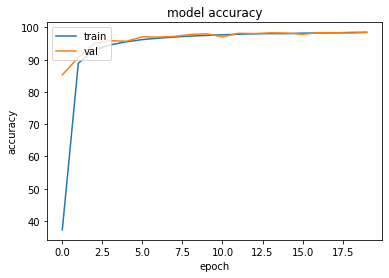

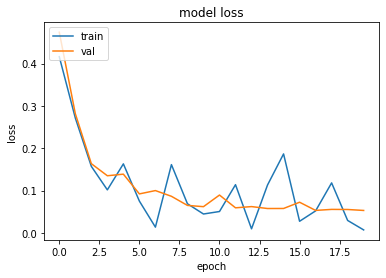

[([37.225,
   88.9,
   93.04333333333334,
   94.595,
   95.55166666666666,
   96.23833333333333,
   96.67833333333333,
   97.02,
   97.33,
   97.525,
   97.74166666666666,
   97.89,
   98.03333333333333,
   98.08833333333334,
   98.085,
   98.24166666666666,
   98.27,
   98.31333333333333,
   98.45833333333333,
   98.515],
  [0.41632094979286194,
   0.27156686782836914,
   0.15725338459014893,
   0.10170852392911911,
   0.16310100257396698,
   0.07513386011123657,
   0.013599857687950134,
   0.16132104396820068,
   0.06885820627212524,
   0.044646937400102615,
   0.05051825940608978,
   0.11391609907150269,
   0.009627108462154865,
   0.11323262006044388,
   0.18664805591106415,
   0.027473732829093933,
   0.051999032497406006,
   0.11815213412046432,
   0.029415419325232506,
   0.007035011891275644]),
 ([85.29,
   90.7,
   95.03,
   95.91,
   95.72,
   97.1,
   97.03,
   97.22,
   97.82,
   98.03,
   97.08,
   98.2,
   98.1,
   98.33,
   98.26,
   97.89,
   98.37,
   98.37,
   98.25,


In [21]:
optimizer1 = optim.SGD(model1.parameters(), lr=0.01, momentum=0.9)
train_n_test(model1, optimizer1, device, train_loader, test_loader, 20)

In [0]:
class Net2(nn.Module):
    def __init__(self):
        super(Net2, self).__init__()
        self.conv1 = nn.Conv2d(1, 16, 3, bias=False) #input -28*28*1 output: 26*26*16 RF: 3*3
        self.conv1_bn = nn.BatchNorm2d(16)
        self.conv1_drop = nn.Dropout2d(0.03)

        self.conv2 = nn.Conv2d(16, 16, 3, bias=False) #input -26*26*16 output: 24*24*16 RF: 5*5
        self.conv2_bn = nn.BatchNorm2d(16)
        self.conv2_drop = nn.Dropout2d(0.03)
        self.conv3 = nn.Conv2d(16, 16, 3, bias=False) #input -24*24*16 output: 22*22*16 RF: 7*7
        self.conv3_bn = nn.BatchNorm2d(16)
        self.conv3_drop = nn.Dropout2d(0.03)

        self.pool1 = nn.MaxPool2d(2, 2) #input - 22*22*16 output: 11*11*16 RF: 8*8
        self.conv4 = nn.Conv2d(16, 16, 1, bias=False) #input -11*11*16 output: 9*9*16 LRF: 3*3 GRF: 12*12
        self.conv4_bn = nn.BatchNorm2d(16)
        self.conv4_drop = nn.Dropout2d(0.03)

        self.conv5 = nn.Conv2d(16, 24, 3, bias=False) #input -11*11*16 output: 9*9*24 LRF: 3*3 GRF: 12*12
        self.conv5_bn = nn.BatchNorm2d(24)
        self.conv5_drop = nn.Dropout2d(0.03)

        self.conv6 = nn.Conv2d(24, 24, 3, bias=False) #input -9*9*24 output: 7*7*24 LRF: 5*5 GRF: 16*16
        self.conv6_bn = nn.BatchNorm2d(24)
        self.conv6_drop = nn.Dropout2d(0.03)

        self.conv7 = nn.Conv2d(24, 10, 1, bias=False) #input -7*7*16 output: 7*7*10 LRF: 5*5 GRF: 16*16
        self.gap = nn.AvgPool2d(kernel_size=7) #input -7*7*10 output: 1*1*10

    def forward(self, x):
        x = F.relu(self.conv1_drop(self.conv1_bn(self.conv1(x))))
        
        x = F.relu(self.conv2_drop(self.conv2_bn(self.conv2(x))))
        x = F.relu(self.conv3_drop(self.conv3_bn(self.conv3(x))))

        x = self.pool1(x)
        x = F.relu(self.conv4_drop(self.conv4_bn(self.conv4(x))))

        x = F.relu(self.conv5_drop(self.conv5_bn(self.conv5(x))))
        x = F.relu(self.conv6_drop(self.conv6_bn(self.conv6(x))))

        x = self.gap(self.conv7(x)) #No activation on conv before last later
        x = x.view(-1, 10)
        return F.log_softmax(x, dim=1)

In [23]:
model2 = Net2().to(device)
summary(model2, input_size=(1, 28, 28))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 16, 26, 26]             144
       BatchNorm2d-2           [-1, 16, 26, 26]              32
         Dropout2d-3           [-1, 16, 26, 26]               0
            Conv2d-4           [-1, 16, 24, 24]           2,304
       BatchNorm2d-5           [-1, 16, 24, 24]              32
         Dropout2d-6           [-1, 16, 24, 24]               0
            Conv2d-7           [-1, 16, 22, 22]           2,304
       BatchNorm2d-8           [-1, 16, 22, 22]              32
         Dropout2d-9           [-1, 16, 22, 22]               0
        MaxPool2d-10           [-1, 16, 11, 11]               0
           Conv2d-11           [-1, 16, 11, 11]             256
      BatchNorm2d-12           [-1, 16, 11, 11]              32
        Dropout2d-13           [-1, 16, 11, 11]               0
           Conv2d-14             [-1, 2

Epoch: 1, Batch Id: 468 Training Loss: 0.29920614 Training Accuracy: 71.3767%: 100%|██████████| 469/469 [00:12<00:00, 38.06it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Epoch:1 -- Test Set, Validation Loss: 0.19481680 Validation Accuracy: 96.5900%



Epoch: 2, Batch Id: 468 Training Loss: 0.22496973 Training Accuracy: 94.3983%: 100%|██████████| 469/469 [00:12<00:00, 38.24it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Epoch:2 -- Test Set, Validation Loss: 0.08717796 Validation Accuracy: 98.0600%



Epoch: 3, Batch Id: 468 Training Loss: 0.12062474 Training Accuracy: 96.2633%: 100%|██████████| 469/469 [00:12<00:00, 39.05it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Epoch:3 -- Test Set, Validation Loss: 0.06131858 Validation Accuracy: 98.3300%



Epoch: 4, Batch Id: 468 Training Loss: 0.13480124 Training Accuracy: 96.9200%: 100%|██████████| 469/469 [00:12<00:00, 40.18it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Epoch:4 -- Test Set, Validation Loss: 0.04357376 Validation Accuracy: 98.7400%



Epoch: 5, Batch Id: 468 Training Loss: 0.10367716 Training Accuracy: 97.2200%: 100%|██████████| 469/469 [00:12<00:00, 37.21it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Epoch:5 -- Test Set, Validation Loss: 0.05084939 Validation Accuracy: 98.4300%



Epoch: 6, Batch Id: 468 Training Loss: 0.05296434 Training Accuracy: 97.6667%: 100%|██████████| 469/469 [00:12<00:00, 37.95it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Epoch:6 -- Test Set, Validation Loss: 0.03820086 Validation Accuracy: 98.8700%



Epoch: 7, Batch Id: 468 Training Loss: 0.08033016 Training Accuracy: 97.8100%: 100%|██████████| 469/469 [00:12<00:00, 38.76it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Epoch:7 -- Test Set, Validation Loss: 0.03622190 Validation Accuracy: 98.9000%



Epoch: 8, Batch Id: 468 Training Loss: 0.07916091 Training Accuracy: 97.8250%: 100%|██████████| 469/469 [00:12<00:00, 37.92it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Epoch:8 -- Test Set, Validation Loss: 0.03248186 Validation Accuracy: 99.0100%



Epoch: 9, Batch Id: 468 Training Loss: 0.11400363 Training Accuracy: 98.0267%: 100%|██████████| 469/469 [00:11<00:00, 39.21it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Epoch:9 -- Test Set, Validation Loss: 0.03202431 Validation Accuracy: 99.0300%



Epoch: 10, Batch Id: 468 Training Loss: 0.04342610 Training Accuracy: 98.1350%: 100%|██████████| 469/469 [00:12<00:00, 37.73it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Epoch:10 -- Test Set, Validation Loss: 0.02910849 Validation Accuracy: 99.1100%



Epoch: 11, Batch Id: 468 Training Loss: 0.03114386 Training Accuracy: 98.2633%: 100%|██████████| 469/469 [00:12<00:00, 38.41it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Epoch:11 -- Test Set, Validation Loss: 0.02856492 Validation Accuracy: 99.1600%



Epoch: 12, Batch Id: 468 Training Loss: 0.07987575 Training Accuracy: 98.3150%: 100%|██████████| 469/469 [00:12<00:00, 38.95it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Epoch:12 -- Test Set, Validation Loss: 0.02695081 Validation Accuracy: 99.0800%



Epoch: 13, Batch Id: 468 Training Loss: 0.08279309 Training Accuracy: 98.3717%: 100%|██████████| 469/469 [00:12<00:00, 38.84it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Epoch:13 -- Test Set, Validation Loss: 0.02431783 Validation Accuracy: 99.2400%



Epoch: 14, Batch Id: 468 Training Loss: 0.07206009 Training Accuracy: 98.3383%: 100%|██████████| 469/469 [00:12<00:00, 38.45it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Epoch:14 -- Test Set, Validation Loss: 0.02396847 Validation Accuracy: 99.2300%



Epoch: 15, Batch Id: 468 Training Loss: 0.10939768 Training Accuracy: 98.5150%: 100%|██████████| 469/469 [00:11<00:00, 39.11it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Epoch:15 -- Test Set, Validation Loss: 0.02384969 Validation Accuracy: 99.3200%



Epoch: 16, Batch Id: 468 Training Loss: 0.02139598 Training Accuracy: 98.4917%: 100%|██████████| 469/469 [00:12<00:00, 38.77it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Epoch:16 -- Test Set, Validation Loss: 0.02261813 Validation Accuracy: 99.3300%



Epoch: 17, Batch Id: 468 Training Loss: 0.09867234 Training Accuracy: 98.6033%: 100%|██████████| 469/469 [00:12<00:00, 38.08it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Epoch:17 -- Test Set, Validation Loss: 0.02274316 Validation Accuracy: 99.2700%



Epoch: 18, Batch Id: 468 Training Loss: 0.00912247 Training Accuracy: 98.5200%: 100%|██████████| 469/469 [00:11<00:00, 39.09it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Epoch:18 -- Test Set, Validation Loss: 0.02236844 Validation Accuracy: 99.3000%



Epoch: 19, Batch Id: 468 Training Loss: 0.08359187 Training Accuracy: 98.5650%: 100%|██████████| 469/469 [00:12<00:00, 38.30it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Epoch:19 -- Test Set, Validation Loss: 0.02337613 Validation Accuracy: 99.3000%



Epoch: 20, Batch Id: 468 Training Loss: 0.05451955 Training Accuracy: 98.5800%: 100%|██████████| 469/469 [00:11<00:00, 40.77it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Epoch:20 -- Test Set, Validation Loss: 0.02280453 Validation Accuracy: 99.2300%



Epoch: 21, Batch Id: 468 Training Loss: 0.01632873 Training Accuracy: 98.7000%: 100%|██████████| 469/469 [00:12<00:00, 34.96it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Epoch:21 -- Test Set, Validation Loss: 0.02254826 Validation Accuracy: 99.2300%



Epoch: 22, Batch Id: 468 Training Loss: 0.02803738 Training Accuracy: 98.6717%: 100%|██████████| 469/469 [00:13<00:00, 36.07it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Epoch:22 -- Test Set, Validation Loss: 0.02312302 Validation Accuracy: 99.2300%



Epoch: 23, Batch Id: 468 Training Loss: 0.05110241 Training Accuracy: 98.6967%: 100%|██████████| 469/469 [00:13<00:00, 34.77it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Epoch:23 -- Test Set, Validation Loss: 0.02287575 Validation Accuracy: 99.1900%



Epoch: 24, Batch Id: 468 Training Loss: 0.04267566 Training Accuracy: 98.7450%: 100%|██████████| 469/469 [00:12<00:00, 38.03it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Epoch:24 -- Test Set, Validation Loss: 0.02138716 Validation Accuracy: 99.2900%



Epoch: 25, Batch Id: 468 Training Loss: 0.04863535 Training Accuracy: 98.7800%: 100%|██████████| 469/469 [00:12<00:00, 38.50it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Epoch:25 -- Test Set, Validation Loss: 0.02106725 Validation Accuracy: 99.2800%



Epoch: 26, Batch Id: 468 Training Loss: 0.01399155 Training Accuracy: 98.7783%: 100%|██████████| 469/469 [00:12<00:00, 38.80it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Epoch:26 -- Test Set, Validation Loss: 0.02276467 Validation Accuracy: 99.2100%



Epoch: 27, Batch Id: 468 Training Loss: 0.00905893 Training Accuracy: 98.7183%: 100%|██████████| 469/469 [00:12<00:00, 36.82it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Epoch:27 -- Test Set, Validation Loss: 0.02031210 Validation Accuracy: 99.3600%



Epoch: 28, Batch Id: 468 Training Loss: 0.10859921 Training Accuracy: 98.8133%: 100%|██████████| 469/469 [00:11<00:00, 39.30it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Epoch:28 -- Test Set, Validation Loss: 0.02031517 Validation Accuracy: 99.3700%



Epoch: 29, Batch Id: 468 Training Loss: 0.04901536 Training Accuracy: 98.8467%: 100%|██████████| 469/469 [00:12<00:00, 39.07it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Epoch:29 -- Test Set, Validation Loss: 0.01937822 Validation Accuracy: 99.4100%



Epoch: 30, Batch Id: 468 Training Loss: 0.06035270 Training Accuracy: 98.8733%: 100%|██████████| 469/469 [00:12<00:00, 38.28it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Epoch:30 -- Test Set, Validation Loss: 0.02026971 Validation Accuracy: 99.3700%



Epoch: 31, Batch Id: 468 Training Loss: 0.01190017 Training Accuracy: 98.9117%: 100%|██████████| 469/469 [00:11<00:00, 39.57it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Epoch:31 -- Test Set, Validation Loss: 0.01891306 Validation Accuracy: 99.4000%



Epoch: 32, Batch Id: 468 Training Loss: 0.02347676 Training Accuracy: 98.8417%: 100%|██████████| 469/469 [00:12<00:00, 41.58it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Epoch:32 -- Test Set, Validation Loss: 0.01903082 Validation Accuracy: 99.3700%



Epoch: 33, Batch Id: 468 Training Loss: 0.03993197 Training Accuracy: 98.8783%: 100%|██████████| 469/469 [00:11<00:00, 40.73it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Epoch:33 -- Test Set, Validation Loss: 0.02053325 Validation Accuracy: 99.2900%



Epoch: 34, Batch Id: 468 Training Loss: 0.05660807 Training Accuracy: 98.9167%: 100%|██████████| 469/469 [00:11<00:00, 39.27it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Epoch:34 -- Test Set, Validation Loss: 0.02091203 Validation Accuracy: 99.3100%



Epoch: 35, Batch Id: 468 Training Loss: 0.05841777 Training Accuracy: 98.9350%: 100%|██████████| 469/469 [00:11<00:00, 40.43it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Epoch:35 -- Test Set, Validation Loss: 0.01931432 Validation Accuracy: 99.3600%



Epoch: 36, Batch Id: 468 Training Loss: 0.00645723 Training Accuracy: 98.9233%: 100%|██████████| 469/469 [00:11<00:00, 39.22it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Epoch:36 -- Test Set, Validation Loss: 0.02080775 Validation Accuracy: 99.2900%



Epoch: 37, Batch Id: 468 Training Loss: 0.04155359 Training Accuracy: 98.9633%: 100%|██████████| 469/469 [00:11<00:00, 40.45it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Epoch:37 -- Test Set, Validation Loss: 0.02106235 Validation Accuracy: 99.2800%



Epoch: 38, Batch Id: 468 Training Loss: 0.04127234 Training Accuracy: 99.0100%: 100%|██████████| 469/469 [00:11<00:00, 41.13it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Epoch:38 -- Test Set, Validation Loss: 0.01875655 Validation Accuracy: 99.3700%



Epoch: 39, Batch Id: 468 Training Loss: 0.01210714 Training Accuracy: 98.9183%: 100%|██████████| 469/469 [00:11<00:00, 39.44it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Epoch:39 -- Test Set, Validation Loss: 0.02008784 Validation Accuracy: 99.3300%



Epoch: 40, Batch Id: 468 Training Loss: 0.02884753 Training Accuracy: 98.9917%: 100%|██████████| 469/469 [00:11<00:00, 39.86it/s]



Epoch:40 -- Test Set, Validation Loss: 0.01906630 Validation Accuracy: 99.3700%



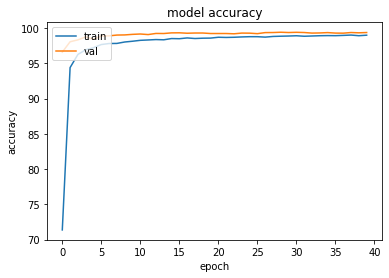

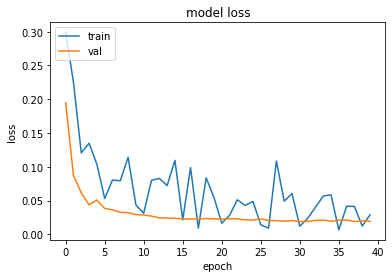

[([71.37666666666667,
   94.39833333333333,
   96.26333333333334,
   96.92,
   97.22,
   97.66666666666667,
   97.81,
   97.825,
   98.02666666666667,
   98.135,
   98.26333333333334,
   98.315,
   98.37166666666667,
   98.33833333333334,
   98.515,
   98.49166666666666,
   98.60333333333334,
   98.52,
   98.565,
   98.58,
   98.7,
   98.67166666666667,
   98.69666666666667,
   98.745,
   98.78,
   98.77833333333334,
   98.71833333333333,
   98.81333333333333,
   98.84666666666666,
   98.87333333333333,
   98.91166666666666,
   98.84166666666667,
   98.87833333333333,
   98.91666666666667,
   98.935,
   98.92333333333333,
   98.96333333333334,
   99.01,
   98.91833333333334,
   98.99166666666666],
  [0.2992061376571655,
   0.22496972978115082,
   0.12062474340200424,
   0.1348012387752533,
   0.1036771610379219,
   0.05296434089541435,
   0.08033015578985214,
   0.0791609063744545,
   0.11400362849235535,
   0.04342610016465187,
   0.031143860891461372,
   0.07987575232982635,
   0.082

In [24]:
optimizer2 = optim.SGD(model2.parameters(), lr=0.001, momentum=0.9)
train_n_test(model2, optimizer2, device, train_loader, test_loader, 40)